In [ ]:
"""
@Josh Boquiren
Ver. I
OTIS Lab MUSC
4.21.2023

README: 
- Revised version of "Population - PFC Self-Admin 7.2.ipynb"
- Better version for handling inactive data

POPULATION:
- Extinction, active and inactive analysis
"""

## PREPROCESSING

Import libraries

In [2]:
#data manipulation
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#directory and file manager
import os

#statistics
import scipy.stats as stats
import scipy.io as sio
from sklearn.metrics import roc_auc_score as auROC
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

# import subprocess
# import time
# import pickle
# import math
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC, SVR, LinearSVC
# from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score, silhouette_sapltes
# from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
# from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
# from sklearn.model_selection import GridSearchCV
# from sklearn.kernel_ridge import KernelRidge
# from sklearn import linear_model
# from sklearn.manifold import TSNE

# from scipy import interpolate

# import statsmodels.formula.api as smf
# from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)

# import matplotlib.cm as cm
# import matplotlib.colors as colors
# import matplotlib.colorbar as colorbar
# import matplotlib.patches as mpatches
# import sys
# import re
# import random
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# np.set_printoptions(suppress=True)


In [3]:
#initialize directories

population = 'EXTINCTION'

basedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data'

earlybasedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data/EarlyExt'
middlebasedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data/LastExt'
latebasedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data/LastExt'

models = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\active-inactive_analysis\universal_models'
results = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\active-inactive_analysis\extinction\results'

#cluster list files
early_newlabels = np.load(os.path.join(earlybasedir, 'cluster_list_per_session_Extinction.npy')) #put clustering files in a folder to loop through
middle_newlabels = np.load(os.path.join(middlebasedir, 'cluster_list_per_session_Extinction.npy'))

#for later plot titles
plot_titles = ['EARLY', 'LATE', '(blank)']
population_title = "EXT"

#animals of interest
early_animals_of_interest = [
    'CTL1',
    'ER-L1','ER-L2',
    'LCDD-PGa1','LCDD-PGa4','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T3','LCDD-PGa-T4',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  
middle_animals_of_interest = [ #really late animals, but coded as middle
    #'ER-L1', #130 #NOT USED
    'LCDD-PGa1', #18
    'LCDD-PGa5', #215
    'LCDD-PGa-T2', #146
    'LCDD-PGa-T3', #106
    #'LCDD-PGa-T4', #117 #NOT USED
    'PGa-T1',#150
    'PGa-T2' #148

    #want 783

    #'CTL1', #doesn't work
    #'ER-L2' doesn't work
    #'LCDD-PGa-T5' #doesn't work
    ]  
late_animals_of_interest = []


### EARLY EXT MICE WITH > 2 ACTIVE PRESSES:
# 'CTL1','ER-L1','ER-L2','LCDD-PGa1','LCDD-PGa4','LCDD-PGa6','LCDD-PGa-T1','LCDD-PGa-T3','LCDD-PGa-T4','PGa-T1','PGa-T2','PGa-T3'

In [4]:
#frame rate variables
frameaveraging = 4
timebetweenframes = 33.3333
framerate = 30
framerate = timebetweenframes/frameaveraging #raw frame rate
averagedframerate = timebetweenframes/frameaveraging #averaged frame rate
print('Frame rate:', framerate)
print('Averaged frame rate:', averagedframerate)

#window size variables
pre_window_size = int(10*framerate) #How many frames per trial before origin to be plotted?
window_size =  int((pre_window_size*2)+(3*framerate)) #How many frames do you want to plot around the origin?
post_window_size = window_size - pre_window_size
baselinefirstframe = 0
baselinelastframe = int(1*framerate)
infusionframe = int(pre_window_size+(3*framerate))
print('Prewindow size:', pre_window_size)
print('Window size:', window_size)
print('Postwindow size:', post_window_size)

#set cell tracking
tracking = 'No' ### 'Yes' or 'No'
sorting = 'Yes' ### 'Yes' or 'No'
sorttoearly = 'No' ###'Yes' or 'No'; This is for sorting, but align to early data. 'Sorting' must also be Yes
csv_id_for_tracking = 'CUE-DRUG-TMT'

#tracking
if tracking == 'Yes':
    population_active_tracked_early = np.nan*np.ones((1,window_size))
    population_active_tracked_middle = np.nan*np.ones((1,window_size))
    population_active_tracked_late = np.nan*np.ones((1,window_size))
    print ('Cell Tracking')
else:
    print ('No Cell Tracking')

Frame rate: 8.333325
Averaged frame rate: 8.333325
Prewindow size: 83
Window size: 190
Postwindow size: 107
No Cell Tracking


In [5]:
#method for fixing dropped frames
def fix_any_dropped_frames(frame_timestamps):
    first_frame = np.array([0])
    last_frame = np.array([int(np.max(frame_timestamps)+(500*timebetweenframes))])
    frame_index_temp = np.concatenate((first_frame,frame_timestamps, last_frame)) ###adds frame to timepoint '0' and an extra 500 frames at end
    frames_missed = [] ###creates empty list for us to add timestamps for missed frames
    for i in range(len(frame_index_temp)-1): ###iterates through each collected frame
            numframes_missed = int(np.round((frame_index_temp[i+1]-frame_index_temp[i])\
                /timebetweenframes)-1) ### number of missed frames per frame interval
            if numframes_missed > 0: 
                for j in range(numframes_missed):
                    frame_missed = np.array([frame_index_temp[i] + (int(timebetweenframes * (j+1)))])
                    frames_missed = np.concatenate((frames_missed, frame_missed))
    corrected_frame_index = np.array(sorted(np.concatenate((frame_index_temp, frames_missed))))
    return corrected_frame_index

#method for fixing assumed frames
def fix_assumed_frames(frames):
    dropped_frames = []
    diff_frames = np.diff(frames)
    inter_frame_interval = 33
    frame_drop_idx = np.where(diff_frames>1.5*inter_frame_interval)[0]
    for idx in frame_drop_idx:
        numframesdropped = int(np.round((frames[idx+1]-frames[idx])/(inter_frame_interval+0.0))-1)
        temp = [frames[idx]+a*inter_frame_interval for a in range(1,numframesdropped+1)]
        dropped_frames.extend(temp)
    corrected_frames = np.sort(np.concatenate((frames, np.array(dropped_frames))))
    return corrected_frames

#generate behavior data
try:
    assumed_frames = np.load(os.path.join(models, 'assumed_frames.npy'))
    assumed_frame_timestamps = np.load(os.path.join(models, 'assumed_frame_timestamps.npy'))
    print("Loaded behavior data.")
except:
    #load in data
    behaviordata_noframes = sio.loadmat(r"C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data\Spreadsheets\matfile_noframes_3.mat")
    eventlog_noframes = np.squeeze(behaviordata_noframes['eventlog'])

    #parse desired data
    max_of_eventlog_noframes = max(eventlog_noframes[:,1]) #all rows, second column
    length_of_eventlog_noframes = len(eventlog_noframes[:,1])
    x = np.vstack((eventlog_noframes, eventlog_noframes, eventlog_noframes))
    x[length_of_eventlog_noframes:,1]= x[length_of_eventlog_noframes:,1]+max_of_eventlog_noframes
    x[length_of_eventlog_noframes*2:,1]= x[length_of_eventlog_noframes*2:,1]+(2*max_of_eventlog_noframes)
    eventlog_noframes = x

    assumed_frames = fix_any_dropped_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    assumed_frame_timestamps = fix_assumed_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO

    np.save(os.path.join(models, 'assumed_frames'), assumed_frames)
    np.save(os.path.join(models, 'assumed_frame_timestamps'), assumed_frame_timestamps)
    print("Behavior data processed and loaded.")


Loaded behavior data.


In [6]:
#various methods

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, color=None, label='', linetype='-'):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], linetype, color=color, label=label)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', markersize=3):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)    
    ax.scatter(x, y, color=color, label='%s p=%.3f\nR$^2$=%.3f'% (plot_label, pvalue, R2), s=markersize)
    ax.plot(temp, temppred, color=color)
    return ax, slope, pvalue, R2


def ismembertol(x, y, tol=1E-6):
    # Are elements of x in y within tolerance of tol?
    # x and y must be 1d numpy arrays
    sortx = np.sort(x)
    orderofx = np.argsort(x)
    sorty = np.sort(y)
    current_y_idx = 0
    result = np.nan*np.zeros(x.shape)
    for i, elt in enumerate(sortx):
        temp = sorty[current_y_idx:]
        if np.any(np.abs(temp-elt)<=tol):
            result[orderofx[i]]=1
        else:
            result[orderofx[i]]=0
        temp = np.argwhere(sorty>elt)
        if temp.size>0:
            current_y_idx = temp[0][0]
    return result

def mkdir_p(path):
    #makes a new directory if it doesn't exist
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise 
            
def framenumberforevent(event, frame_timestamps):
    framenumber = np.nan*np.zeros(event.shape)
    for ie, e in enumerate(event):
        #print('     e:', e)
        if np.isnan(e):
            framenumber[ie] = np.nan
        else:
            temp = np.nonzero(frame_timestamps<=e)[0]
            if temp.shape[0]>0:
                framenumber[ie] = np.nonzero(frame_timestamps<=e)[0][-1]
            else:
                framenumber[ie] = 0
    return framenumber

def calculate_num_licks_for_each_frame(framenumberforlicks, numframes):
    numlicksperframe = np.nan*np.ones((numframes,))
    for i in range(numframes):
        numlicksperframe[i] = np.sum(framenumberforlicks==i)
    return numlicksperframe

def calculate_auROC(x,y,offset_to_zero=True):
    U, p = stats.mannwhitneyu(x,y)
    labels = np.concatenate((np.ones(x.shape), np.zeros(y.shape)))
    data = np.concatenate((x,y))
    A = auROC(labels, data)
    if offset_to_zero:
        return (2*(A-0.5), p)
    else:
        return (A, p)
    
def Benjamini_Hochberg_correction(vector_of_pvals,
                                  alpha = 0.05):
    # This function ipltements the BH FDR correction
    
    # Parameters:
    # Vector of p values from the different tests
    # alpha:significance level
    
    # Returns: Corrected p values. All the p values that are above the FDR threshold are set to 1. 
    #          Remaining p values are unchanged.
    
    sortedpvals = np.sort(vector_of_pvals)
    orderofpvals = np.argsort(vector_of_pvals)
    m = sortedpvals[np.isfinite(sortedpvals)].shape[0] #Total number of hypotheses
    for i in range(m):
        if sortedpvals[i] > (i+1)*alpha/m:
            k = i
            break
        elif i == m-1:
            k = m-1
        
    correctedpvals = np.copy(vector_of_pvals)
    correctedpvals[orderofpvals[k:]] = 1
    correctedpvals[np.isnan(vector_of_pvals)] = np.nan
    return correctedpvals

In [6]:
#method for animal analysis
def analyze_single_session(indir, window_size, pre_window_size):    
    tempfiles = next(os.walk(indir))[2]
    npyfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
        and 'extractedsignals_raw' in f]
    matfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat']

    if len(npyfiles) > 1:
        npyfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
            and 'extractedsignals_raw' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        if npyfile[0][0]!='nan':
            npyfile = npyfile [0]
        matfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' 
            and not 'results' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        matfile = matfile [0]
    else:
        npyfile = npyfiles[0]
        matfile = matfiles[0]
    
    signals = np.squeeze(np.load(os.path.join(indir, npyfile)))
    numneurons = signals.shape[0] 
   
    behaviordata = sio.loadmat(os.path.join(indir, matfile))
    eventlog = np.squeeze(behaviordata['eventlog'])
    licks = np.squeeze(behaviordata['licks'])
    lastframe_timestamp_part1 = np.max(eventlog)
    
    if len(npyfiles) > 1:
        npyfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part2' in f]
        matfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part2' in f and not 'results' in f]
        npyfile2 = npyfiles2[0]
        matfile2 = matfiles2[0]
        signals2 = np.squeeze(np.load(os.path.join(indir, npyfile2))) 
        if signals2[0][0]!='nan':
            signals = np.hstack((signals, signals2))
        behaviordata2 = sio.loadmat(os.path.join(indir, matfile2))
        eventlog2 = np.squeeze(behaviordata2['eventlog'])
        eventlog2[:,1] = eventlog2[:,1]+lastframe_timestamp_part1  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog2))
        lastframe_timestamp_part2 = np.max(eventlog)        
        licks2 = np.squeeze(behaviordata2['licks'])
        licks2 = licks2+lastframe_timestamp_part1
        licks = np.concatenate ([licks, licks2])
    if len(npyfiles) > 2:
        npyfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part3' in f]
        matfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part3' in f and not 'results' in f]
        npyfile3 = npyfiles3[0]
        matfile3 = matfiles3[0]
        signals3 = np.squeeze(np.load(os.path.join(indir, npyfile3))) 
        if signals3[0][0]!='nan':
            signals = np.hstack((signals, signals3))
        behaviordata3 = sio.loadmat(os.path.join(indir, matfile3))
        eventlog3 = np.squeeze(behaviordata3['eventlog'])
        eventlog3[:,1] = eventlog3[:,1]+lastframe_timestamp_part2  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog3))
        lastframe_timestamp_part3 = np.max(eventlog)
        licks3 = np.squeeze(behaviordata3['licks'])
        licks3 = licks3+lastframe_timestamp_part2
        licks = np.concatenate ([licks, licks3])
    if len(npyfiles) > 3:
        npyfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' and 'part4' in f]
        matfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part4' in f and not 'results' in f]
        npyfile4 = npyfiles4[0]
        matfile4 = matfiles4[0]
        signals4 = np.squeeze(np.load(os.path.join(indir, npyfile4))) 
        if signals4[0][0]!='nan':
            signals = np.hstack((signals, signals4))
        behaviordata4 = sio.loadmat(os.path.join(indir, matfile4))
        eventlog4 = np.squeeze(behaviordata4['eventlog'])
        eventlog4[:,1] = eventlog4[:,1]+lastframe_timestamp_part3  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog4))
        lastframe_timestamp_part4 = np.max(eventlog)
        licks4 = np.squeeze(behaviordata4['licks'])
        licks4 = licks4+lastframe_timestamp_part3
        licks = np.concatenate ([licks, licks4])
    #pulling data from eventlog
    activelever = eventlog[eventlog[:,0]==22,1]
    activelevertimeout = eventlog[eventlog[:,0]==222,1]
    inactivelever = eventlog[eventlog[:,0]==21,1]
    inactivelevertimeout = eventlog[eventlog[:,0]==212,1]
    cues = eventlog[eventlog[:,0]==7,1]
    infusions = eventlog[eventlog[:,0]==4,1]    

    signals /= np.mean(signals, axis=1)[:, None]
    signalsT = signals.T






    
    
    ###IF YOUR CODE LACKS FRAME INPUTS, WE CAN ATTEMPT TO PREDICT FRAME TIMING BY USING PREVIOUS FRAME TIMESTAMPS
    if animal == 'CTL1' or animal == 'ER-L1' or animal == 'ER-L2' or animal == 'IG-19' or animal == 'IG-28' or animal == 'PGa-T1' or animal == 'XYZ':
        frame_timestamps = assumed_frame_timestamps ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    else:
        frame_timestamps = fix_any_dropped_frames(eventlog[eventlog[:,0]==9,1]) 
    frame_timestamps = frame_timestamps[::frameaveraging] ###incorporates averaging into timestamp array
    
    ###DISCARDS BEHAVIORAL EVENTS THAT WERE NOT FULLY MONITORED WITH IMAGING
    if signals.shape[1] > frame_timestamps.shape[0]:
        signals = signals[:,:frame_timestamps.shape[0]-1] ###cuts signals so it's not longer than the frame timestamps
        
    final_frame_timestamp = frame_timestamps[signals.shape[1]] #This is the timestamp of the final frame in milliseconds
    activelever = activelever[activelever<(final_frame_timestamp-(window_size/framerate*1000))]
    activelevertimeout = activelevertimeout[activelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelever = inactivelever[inactivelever<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelevertimeout = inactivelevertimeout[inactivelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    
    seconds_monitored = int(signals.shape[1]/averagedframerate) ###seconds monitored by 2p imaging
    seconds_behavior = int(max(activelever/1000)) ###final seconds to be monitored for behavior

    if seconds_monitored < seconds_behavior: #calculates last fully-monitored active lever press with 2p recording
        included_trials = []
        discarded_trials=[]
        for i in range(len(activelever)):
            if activelever[i]/1000<seconds_monitored:
                included_trials=np.append(included_trials, activelever[i])
            else:
                discarded_trials=np.append(discarded_trials,activelever[i]) #FIXME why is this even here?
        activelever=included_trials 
    #combines all presses
    activeleverall = np.hstack((activelever, activelevertimeout))
    inactiveleverall = np.hstack((inactivelever, inactivelevertimeout))

    #FIXME
    if activeleverall.shape[0] < 6:
        activeleverall =np.array([])
    if inactiveleverall.shape[0] < 6:
        inactiveleverall = np.array([])
    print('Signals.T:', signalsT.shape, 'Active:', activeleverall.shape, 'Inactive:',inactiveleverall.shape )
 
    #method for calculating aligned data
    def calculate_aligneddata_forevent(data, frame_after_event): #FIXME
        framenumberfor_eventofinterest = np.squeeze(framenumberforevent(frame_after_event, frame_timestamps))
        numtrials = framenumberfor_eventofinterest.shape[0]
        if data.size==signals.size:
            align = np.NAN*np.zeros([numtrials,window_size,numneurons])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size,numneurons])###CHANGED ON AUGUST 20 2021
        else:
            align = np.NAN*np.zeros([numtrials,window_size])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size])
        temp = data
        prevendindex = 0
        for i in range(numtrials):  ###CHANGED THIS SECTION ON AUGUST 20 2021
            print(i)
            tempindex = framenumberfor_eventofinterest[i]
            if np.isfinite(tempindex):
                tempindex = int(tempindex)
                tempstartindex = np.amin([pre_window_size, tempindex]).astype(int)
                startindex = np.amin([tempstartindex, tempindex-prevendindex]).astype(int)
                tempendindex = np.amin([len(frame_timestamps)-tempindex, post_window_size])
                print('  tempindex',tempindex)
                print('  tempstartindex',tempstartindex)
                print('  startindex',startindex)
                print('  tempendindex',tempendindex)
                if i<(numtrials-1) and np.isfinite(framenumberfor_eventofinterest[i+1]):
                    #endindex = np.amin([framenumberfor_eventofinterest[i+1]-tempindex, tempendindex]).astype(int)
                    #print('  endindex', endindex)
                    endindex = tempendindex
                    print('  endindex', endindex)
                else:
                    #endindex = tempendindex.astype(int) 
                    endindex = tempendindex
                    print('  endindex', endindex) 
                    prevendindex = tempindex+endindex
                if temp.shape[0]!=temp.size:
                    print('     T1 align to plot:', (align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex,:]).shape)
                    print('     T2 temp:', (temp[tempindex-startindex:tempindex+endindex,:]).shape) #FIXME -> throwing index error
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex,:] = temp[tempindex-startindex:tempindex+endindex,:]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex,:] = temp[tempindex-tempstartindex:tempindex+endindex,:]
                else: 
                    print((align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex,:]).shape)
                    print((temp[tempindex-startindex:tempindex+endindex,:]).shape)
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex] = temp[tempindex-startindex:tempindex+endindex]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex] = temp[tempindex-tempstartindex:tempindex+endindex]
            else:
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,:,:] = np.nan*np.ones((window_size, numneurons))
                    align[i,:,:] = np.nan*np.ones((window_size, numneurons))
                else:
                    align_to_plot[i,:] = np.nan*np.ones((window_size))
                    align[i,:] = np.nan*np.ones((window_size))
        if temp.shape[0]!=temp.size:         
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0]))[0],:]     
        else:
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0]))[0],:]
        return align, align_to_plot, framenumberfor_eventofinterest
    
    print('start active calculation')
    align_activelever, align_to_plot_activelever, framenumberfor_frameafter_activelever = \
        calculate_aligneddata_forevent(signalsT, activeleverall)  
    populationdata_activelever = np.nanmean(align_activelever, axis=0).T-1
    print('end active calculation')

    print('start inactive calculation')
    align_inactivelever, align_to_plot_inactivelever, framenumberfor_frameafter_inactivelever = \
        calculate_aligneddata_forevent(signalsT, inactiveleverall) #FIXME
    populationdata_inactivelever = np.nanmean(align_inactivelever, axis=0).T-1
    print('end inactive calculation')
    
    for i in range(signals.shape[0]):
        if np.isnan(np.mean(signals[i,:])):
            print(animal, fov, 'IMAGE J ROI.ZIP CELL NUMBER %s HAS NaNs AND SHOULD BE CHANGED'%(i+1))
        
    return populationdata_activelever, populationdata_inactivelever, align_activelever, align_inactivelever, framerate

#### Making single session analysis files

In [36]:
#Early population
excluded = []
for animal in early_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        temp_active = np.nan*np.ones((1, window_size))
        temp_inactive = np.nan*np.ones((1, window_size))
        for fov in sorted(FOVs):
            try:
                temp1, temp2, temp3, temp4, framerate = analyze_single_session(
                    #analysis parameters
                    os.path.join(earlybasedir, animal, fov), 
                    window_size, 
                    pre_window_size
                    )
                #saving active and inactive signal data (includig NaN rows)
                temp_active = np.vstack((temp_active, temp1))
                temp_inactive = np.vstack((temp_inactive, temp2))
                #saving aligned active and inactive lever data
                temp_align_active_lever = temp3
                temp_align_inactive_lever = temp4
            except Exception as e:
                print('***ERROR:', e, '***')
                excluded.append(animal)
            #files for signal data with NaN's
            np.save(os.path.join(earlybasedir, animal, fov, "active"), temp_active[1:,:])
            np.save(os.path.join(earlybasedir, animal, fov, "inactive"), temp_inactive[1:,:])
            #files for aligned lever data
            np.save(os.path.join(earlybasedir, animal, fov, "aligned_active_lever_data"), temp_align_active_lever)
            np.save(os.path.join(earlybasedir, animal, fov, "aligned_inactive_lever_data"), temp_align_inactive_lever)
print('Early excluded animals:', excluded)

>>> CTL1
Signals.T: (82421, 121) Active: (30,) Inactive: (0,)
start active calculation
0
  tempindex 1538
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 121)
     T2 temp: (190, 121)
1
  tempindex 1539
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 121)
     T2 temp: (190, 121)
2
  tempindex 1543
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 121)
     T2 temp: (190, 121)
3
  tempindex 2285
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 121)
     T2 temp: (190, 121)
4
  tempindex 5609
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 121)
     T2 temp: (190, 121)
5
  tempindex 8930
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 121)
     T2 temp: (190, 121)
6
  tempindex 8932
  temp

C:\Users\jboqu\AppData\Local\Temp\ipykernel_26344\2002071708.py:206: RuntimeWarning: Mean of empty slice
  populationdata_inactivelever = np.nanmean(align_inactivelever, axis=0).T-1


Signals.T: (80022, 257) Active: (28,) Inactive: (8,)
start active calculation
0
  tempindex 216
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 257)
     T2 temp: (190, 257)
1
  tempindex 220
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 257)
     T2 temp: (190, 257)
2
  tempindex 223
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 257)
     T2 temp: (190, 257)
3
  tempindex 230
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 257)
     T2 temp: (190, 257)
4
  tempindex 352
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 257)
     T2 temp: (190, 257)
5
  tempindex 354
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 257)
     T2 temp: (190, 257)
6
  tempindex 436
  tempstartindex 83
  

StopIteration: 

In [33]:
#Middle population
excluded = []
for animal in middle_animals_of_interest:
    print('\n>>>', animal)
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
            temp_active = np.nan*np.ones((1, window_size))
            temp_inactive = np.nan*np.ones((1, window_size))
            try:
                for fov in sorted(FOVs):
                    temp1, temp2, temp3, temp4, framerate = analyze_single_session(
                        #analysis parameters
                        os.path.join(middlebasedir, animal, fov), 
                        window_size, 
                        pre_window_size
                        )
                    #saving active and inactive signal data (includig NaN rows)
                    temp_active = np.vstack((temp_active, temp1))
                    temp_inactive = np.vstack((temp_inactive, temp2))
                    #saving aligned active and inactive lever data
                    temp_align_active_lever = temp3
                    temp_align_inactive_lever = temp4
            except Exception as e:
                    print('***ERROR:', e, '***')
                    excluded.append(animal)
            #files for signal data without NaN's
            np.save(os.path.join(middlebasedir, animal, fov, "active"), temp_active[1:,:])
            np.save(os.path.join(middlebasedir, animal, fov, "inactive"), temp_inactive[1:,:])
            #files for aligned lever data
            np.save(os.path.join(middlebasedir, animal, fov, "aligned_active_lever_data"), temp_align_active_lever)
            np.save(os.path.join(middlebasedir, animal, fov, "aligned_inactive_lever_data"), temp_align_inactive_lever)
print('Middle excluded animals:', excluded)


>>> LCDD-PGa1
Signals.T: (53919, 18) Active: (6,) Inactive: (0,)
start active calculation
0
  tempindex 11379
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 18)
     T2 temp: (190, 18)
1
  tempindex 11385
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 18)
     T2 temp: (190, 18)
2
  tempindex 41539
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 18)
     T2 temp: (190, 18)
3
  tempindex 41562
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 18)
     T2 temp: (190, 18)
4
  tempindex 45193
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 18)
     T2 temp: (190, 18)
5
  tempindex 45329
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 18)
     T2 temp: (190, 18)
end active calculation
star

C:\Users\jboqu\AppData\Local\Temp\ipykernel_26344\2002071708.py:206: RuntimeWarning: Mean of empty slice
  populationdata_inactivelever = np.nanmean(align_inactivelever, axis=0).T-1


Signals.T: (53919, 215) Active: (6,) Inactive: (0,)
start active calculation
0
  tempindex 459
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 215)
     T2 temp: (190, 215)
1
  tempindex 490
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 215)
     T2 temp: (190, 215)
2
  tempindex 533
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 215)
     T2 temp: (190, 215)
3
  tempindex 545
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 215)
     T2 temp: (190, 215)
4
  tempindex 9224
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 215)
     T2 temp: (190, 215)
5
  tempindex 38931
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 215)
     T2 temp: (190, 215)
end active calculation
start inactive 

C:\Users\jboqu\AppData\Local\Temp\ipykernel_26344\2002071708.py:200: RuntimeWarning: Mean of empty slice
  populationdata_activelever = np.nanmean(align_activelever, axis=0).T-1


Signals.T: (53919, 106) Active: (7,) Inactive: (14,)
start active calculation
0
  tempindex 41981
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 106)
     T2 temp: (190, 106)
1
  tempindex 45498
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 106)
     T2 temp: (190, 106)
2
  tempindex 45501
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 106)
     T2 temp: (190, 106)
3
  tempindex 46850
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 106)
     T2 temp: (190, 106)
4
  tempindex 47039
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 106)
     T2 temp: (190, 106)
5
  tempindex 47053
  tempstartindex 83
  startindex 83
  tempendindex 107
  endindex 107
     T1 align to plot: (190, 106)
     T2 temp: (190, 106)
6
  tempindex 47055
  tempst

In [9]:
#Late population
excluded = []
for animal in late_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
    for fov in sorted(FOVs):
            temp_active = np.nan*np.ones((1, window_size))
            temp_inactive = np.nan*np.ones((1, window_size))
            for fov in sorted(FOVs):
                try:
                    temp1, temp2, temp3, temp4, framerate = analyze_single_session(
                        #analysis parameters
                        os.path.join(latebasedir, animal, fov), 
                        window_size, 
                        pre_window_size
                        )
                    #saving active and inactive signal data (includig NaN rows)
                    print('Temp active shape:', temp_active.shape, 'Temp1 shape:', temp1.shape)
                    temp_active = np.vstack((temp_active, temp1))
                    temp_inactive = np.vstack((temp_inactive, temp2))
                    #saving aligned active and inactive lever data
                    temp_align_active_lever = temp3
                    temp_align_inactive_lever = temp4
                except Exception as e:
                    print('***ERROR:', e, '***')
                    excluded.append(animal)
                #files for signal data without NaN's
                np.save(os.path.join(latebasedir, animal, fov, "active"), temp_active[1:,:])
                np.save(os.path.join(latebasedir, animal, fov, "inactive"), temp_inactive[1:,:])
                #files for aligned lever data
                np.save(os.path.join(latebasedir, animal, fov, "aligned_active_lever_data"), temp_align_active_lever)
                np.save(os.path.join(latebasedir, animal, fov, "aligned_inactive_lever_data"), temp_align_inactive_lever)
print('Late excluded animals:', excluded)

Late excluded animals: []


### Stacking data

#### All population data

In [7]:
#method for stacking data
def stack_data(indir, animals_of_interest, window, signals_file, aligned_levers_file):
    temp_data = np.nan*np.ones((1, window))
    for animal in animals_of_interest:
            FOVs = next(os.walk(os.path.join(indir, animal)))[1]
            for fov in sorted(FOVs):
                    try:
                        #load in data
                        signal_data = np.load(os.path.join(indir, animal, fov, signals_file))
                        lever_data = np.load(os.path.join(indir, animal, fov, aligned_levers_file))
                        #stack data
                        temp_data = np.vstack((temp_data, signal_data))
                    except Exception as e:
                        print('***ERROR:', e, ' ***')
    data = temp_data[1:,:]
    return(data, lever_data)

In [8]:
#stacking early data

#early active data
temp_early_active, early_active_levers = stack_data(earlybasedir, early_animals_of_interest, window_size, "active.npy", 'aligned_active_lever_data.npy')

#num neurons
numneurons_early_active = temp_early_active.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_early_active[:,baselinefirstframe:baselinelastframe], axis=1)
early_active = temp_early_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(early_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_early_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
early_active_mean = np.nanmean(early_active, axis=0)


#early inactive data
temp_early_inactive, early_inactive_levers = stack_data(earlybasedir, early_animals_of_interest, window_size, "inactive.npy", 'aligned_inactive_lever_data.npy')

#num neurons
numneurons_early_inactive = temp_early_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_early_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
early_inactive = temp_early_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(early_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_early_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
early_inactive_mean = np.nanmean(early_inactive, axis=0)

print('Active shape:', early_active.shape)
print('Active lever shape:', early_active_levers.shape)
print('Inative shape:', early_inactive.shape)
print('Inctive lever shape:', early_inactive_levers.shape)

Active shape: (1401, 190)
Active lever shape: (7, 190, 110)
Inative shape: (1401, 190)
Inctive lever shape: (0, 190, 110)


C:\Users\jboqu\AppData\Local\Temp\ipykernel_30432\2332505228.py:32: RuntimeWarning: Mean of empty slice
  tempresponse = np.nanmean(early_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)


In [9]:
#stacking middle data

#middle active data
temp_middle_active, middle_active_levers = stack_data(middlebasedir, middle_animals_of_interest, window_size, "active.npy", 'aligned_active_lever_data.npy')

#num neurons is length of data
numneurons_middle_active = temp_middle_active.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_middle_active[:,baselinefirstframe:baselinelastframe], axis=1)
middle_active = temp_middle_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(middle_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_middle_active = np.argsort(tempresponse)[::-1]

#calculating the mean
middle_active_mean = np.nanmean(middle_active, axis=0)


#middle inactive data
temp_middle_inactive, middle_inactive_levers = stack_data(middlebasedir, middle_animals_of_interest, window_size, "inactive.npy", 'aligned_inactive_lever_data.npy')

#num neurons is length of data
numneurons_middle_inactive = temp_middle_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_middle_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
middle_inactive = temp_middle_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(middle_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_middle_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean
middle_inactive_mean = np.nanmean(middle_inactive, axis=0)

print('Active shape:', middle_active.shape)
print('Active lever shape:', middle_active_levers.shape)
print('Inative shape:', middle_inactive.shape)
print('Inctive lever shape:', middle_inactive_levers.shape)

Active shape: (783, 190)
Active lever shape: (6, 190, 148)
Inative shape: (783, 190)
Inctive lever shape: (0, 190, 148)


C:\Users\jboqu\AppData\Local\Temp\ipykernel_30432\1902834105.py:14: RuntimeWarning: Mean of empty slice
  tempresponse = np.nanmean(middle_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
C:\Users\jboqu\AppData\Local\Temp\ipykernel_30432\1902834105.py:32: RuntimeWarning: Mean of empty slice
  tempresponse = np.nanmean(middle_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)


#### Data based on criteria

In [10]:
#arrays based on different criteria

animals_based_on_presses = [
     
]

females = [
    'PGa-T2',
    'LCDD-PGa-T3',
    ]

males = [
    'LCDD-PGa1',
    'PGa-T1',
] 



In [11]:
#method for matching neurons to clusters based on criteria
def find_indexes(indir, sub_animals_of_interest_array, original_full_stack, signal_file, cluster_labels_file):
    indexes = []
    for animal in sub_animals_of_interest_array:
        FOVs = next(os.walk(os.path.join(indir, animal)))[1]
        for fov in sorted(FOVs):
            signal_data = np.load(os.path.join(indir, animal, fov, signal_file))
            for neuron in range(len(signal_data)):
                for row in range(len(original_full_stack)):
                    if np.equal(signal_data[neuron], original_full_stack[row])[0]==True:
                        indexes.append({'Animal': animal, 'Stack index': row, 'Cluster': cluster_labels_file[row]})
    indexes = pd.DataFrame(indexes)
    return(indexes)

##### Females vs. Males

In [12]:
#early female data

#dataframe of female animal active data indexes
females_early_active = find_indexes(earlybasedir, females, temp_early_active, 'active.npy', early_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in females_early_active['Stack index']:
    temp_stack = np.vstack((temp_stack, early_active[index]))
females_early_active = temp_stack[1:,:]

#num neurons
numneurons_females_early_active = females_early_active.shape[0]

#calculating population data - baseline
baseline = np.mean(females_early_active[:,baselinefirstframe:baselinelastframe], axis=1)
females_early_active_minus_baseline = females_early_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(females_early_active_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_females_early_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
females_early_active_mean = np.nanmean(females_early_active, axis=0)



##dataframe of female animal active data indexes
#females_early_inactive = find_indexes(earlybasedir, females, temp_early_inactive, 'inactive.npy', early_newlabels)

#temp_stack = np.nan*np.ones((1, window_size))
#for index in females_early_inactive['Stack index']:
#    temp_stack = np.vstack((temp_stack, early_inactive[index]))
#females_early_inactive = temp_stack[1:,:]

##num neurons
#numneurons_females_early_inactive = females_early_inactive.shape[0]

##calculating population data - baseline
#baseline = np.mean(females_early_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
#females_early_inactive_minus_baseline = females_early_inactive - baseline[:,None]

##sorting data
#tempresponse = np.nanmean(females_early_inactive_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
#sortresponse_females_early_inactive = np.argsort(tempresponse)[::-1]

##calculating the mean using pandas
#females_early_inactive_mean = np.nanmean(females_early_inactive, axis=0)

In [13]:
#middle female data

#dataframe of female animal active data indexes
females_middle_active = find_indexes(middlebasedir, females, temp_middle_active, 'active.npy', middle_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in females_middle_active['Stack index']:
    temp_stack = np.vstack((temp_stack, middle_active[index]))
females_middle_active = temp_stack[1:,:]

#num neurons
numneurons_females_middle_active = females_middle_active.shape[0]

#calculating population data - baseline
baseline = np.mean(females_middle_active[:,baselinefirstframe:baselinelastframe], axis=1)
females_middle_active_minus_baseline = females_middle_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(females_middle_active_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_females_middle_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
females_middle_active_mean = np.nanmean(females_middle_active, axis=0)



##dataframe of female animal inactive data indexes
#females_middle_inactive = find_indexes(middlebasedir, females, temp_middle_inactive, 'inactive.npy', middle_newlabels)

#temp_stack = np.nan*np.ones((1, window_size))
#for index in females_middle_inactive['Stack index']:
#    temp_stack = np.vstack((temp_stack, middle_inactive[index]))
#females_middle_inactive = temp_stack[1:,:]

##num neurons
#numneurons_females_middle_inactive = females_middle_inactive.shape[0]

##calculating population data - baseline
#baseline = np.mean(females_middle_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
#females_middle_inactive_minus_baseline = females_middle_inactive - baseline[:,None]

##sorting data
#tempresponse = np.nanmean(females_middle_inactive_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
#sortresponse_females_middle_inactive = np.argsort(tempresponse)[::-1]

##calculating the mean using pandas
#females_middle_inactive_mean = np.nanmean(females_middle_inactive, axis=0)

In [14]:
#early male data

#dataframe of male animal active data indexes
males_early_active = find_indexes(earlybasedir, males, temp_early_active, 'active.npy', early_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in males_early_active['Stack index']:
    temp_stack = np.vstack((temp_stack, early_active[index]))
males_early_active = temp_stack[1:,:]

#num neurons
numneurons_males_early_active = males_early_active.shape[0]

#calculating population data - baseline
baseline = np.mean(males_early_active[:,baselinefirstframe:baselinelastframe], axis=1)
males_early_active_minus_baseline = males_early_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(males_early_active_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_males_early_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
males_early_active_mean = np.nanmean(males_early_active, axis=0)



##dataframe of male animal active data indexes
#males_early_inactive = find_indexes(earlybasedir, males, temp_early_inactive, 'inactive.npy', early_newlabels)

#temp_stack = np.nan*np.ones((1, window_size))
#for index in males_early_inactive['Stack index']:
#    temp_stack = np.vstack((temp_stack, early_inactive[index]))
#males_early_inactive = temp_stack[1:,:]

##num neurons
#numneurons_males_early_inactive = males_early_inactive.shape[0]

##calculating population data - baseline
#baseline = np.mean(males_early_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
#males_early_inactive_minus_baseline = males_early_inactive - baseline[:,None]

##sorting data
#tempresponse = np.nanmean(males_early_inactive_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
#sortresponse_males_early_inactive = np.argsort(tempresponse)[::-1]

##calculating the mean using pandas
#males_early_inactive_mean = np.nanmean(males_early_inactive, axis=0)

In [15]:
#middle male data

#dataframe of male animal active data indexes
males_middle_active = find_indexes(middlebasedir, males, temp_middle_active, 'active.npy', middle_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in males_middle_active['Stack index']:
    temp_stack = np.vstack((temp_stack, middle_active[index]))
males_middle_active = temp_stack[1:,:]

#num neurons
numneurons_males_middle_active = males_middle_active.shape[0]

#calculating population data - baseline
baseline = np.mean(males_middle_active[:,baselinefirstframe:baselinelastframe], axis=1)
males_middle_active_minus_baseline = males_middle_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(males_middle_active_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_males_middle_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
males_middle_active_mean = np.nanmean(males_middle_active, axis=0)



##dataframe of male animal inactive data indexes
#males_middle_inactive = find_indexes(middlebasedir, males, temp_middle_inactive, 'inactive.npy', middle_newlabels)

#temp_stack = np.nan*np.ones((1, window_size))
#for index in males_middle_inactive['Stack index']:
#    temp_stack = np.vstack((temp_stack, middle_inactive[index]))
#males_middle_inactive = temp_stack[1:,:]

##num neurons
#numneurons_males_middle_inactive = males_middle_inactive.shape[0]

##calculating population data - baseline
#baseline = np.mean(males_middle_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
#males_middle_inactive_minus_baseline = males_middle_inactive - baseline[:,None]

##sorting data
#tempresponse = np.nanmean(males_middle_inactive_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
#sortresponse_males_middle_inactive = np.argsort(tempresponse)[::-1]

##calculating the mean using pandas
#males_middle_inactive_mean = np.nanmean(males_middle_inactive, axis=0)

### Plots

#### All data

In [14]:
#filter out the NaN values
def filter_NAN(processed_data, windowsize, prewindowsize, framerate):
        filtered_stack = np.nan*np.ones((1, windowsize))
        for row in processed_data:
                if np.isfinite(row[0]):
                        filtered_stack = np.vstack((filtered_stack, row))
        filtered_stack = filtered_stack[1:,:]
        response = np.nanmean(filtered_stack[:,prewindowsize-(1*int(framerate)):prewindowsize+1*int(framerate)], axis=1)
        sortresponse = np.argsort(response)[::-1]
        return(filtered_stack, sortresponse)

C:\Users\jboqu\AppData\Local\Temp\ipykernel_26344\668129618.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([pre_window_size, pre_window_size],


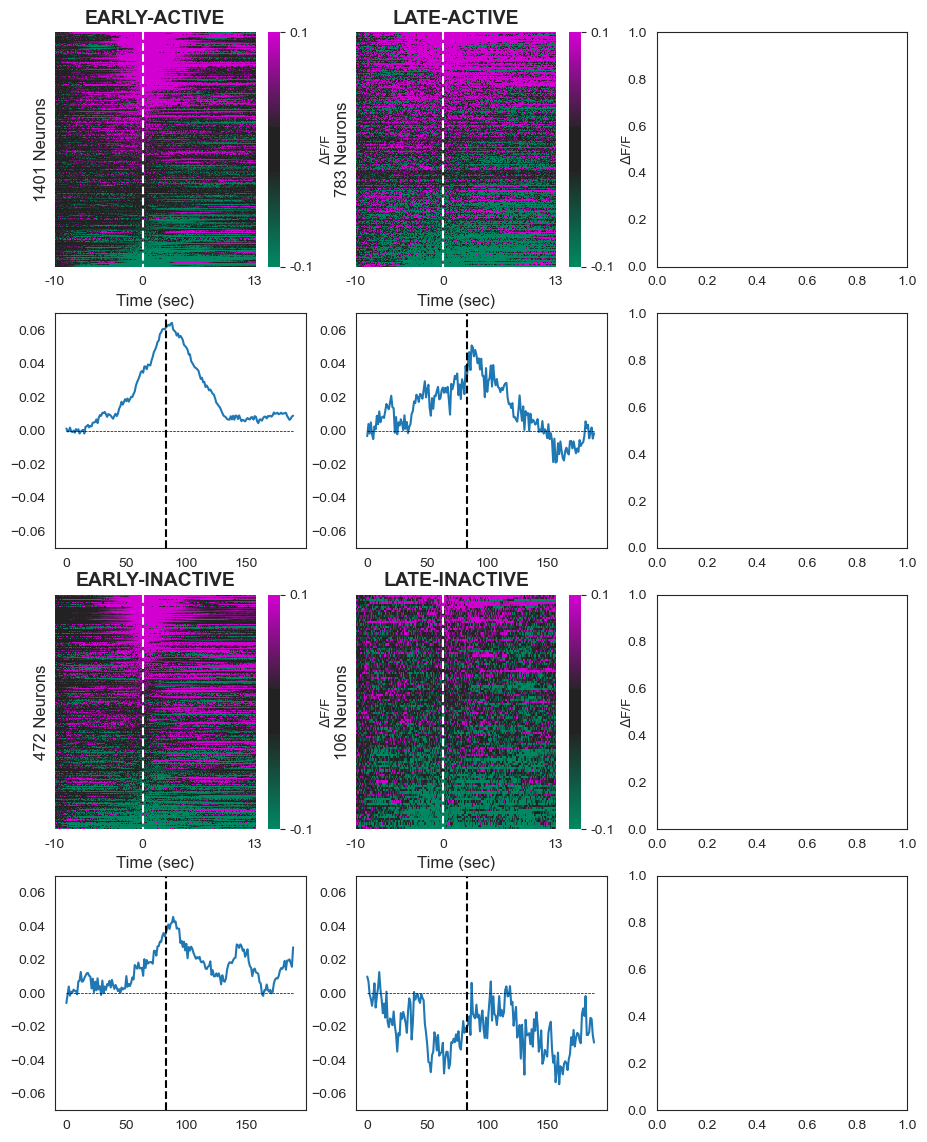

In [29]:
#plot

# initialize the plot
# 2 rows and 3 columns of graphs; may end up with blank column
fig, axs = plt.subplots(4, 3, figsize=(11, 14))
sns.set_style('white')

# setting max/min variables
cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax

# early active plots
ax = axs[0, 0]

# heatmap
hm = sns.heatmap(early_active[sortresponse_early_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1]) #<-- set tick index
ax.set(xticklabels=["-10", "0", "13"]) #<-- set tick labels

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_early_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_early_active], '--k', linewidth=1.5, color='white') #leverpress line <-- change line color

# line plot
ax = axs[1, 0]
ax.plot(early_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

# early inactive plots (sorted to active plot)
ax = axs[2, 0]

#filtering NaN's
sorted_early_inactive, inactive_sort = filter_NAN(early_inactive, window_size, pre_window_size, framerate)

# heatmap
hm = sns.heatmap(sorted_early_inactive[inactive_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % sorted_early_inactive.shape[0], fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_early_inactive], '--', linewidth=1.5, color='white')

# line plot
ax = axs[3, 0]
ax.plot(early_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

# middle active plots
ax = axs[0, 1]

#filtering NaN's
sorted_middle_active, middle_active_sort = filter_NAN(middle_active, window_size, pre_window_size, framerate)

# heatmap
hm = sns.heatmap(sorted_middle_active[middle_active_sort, :], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_middle_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_middle_active], '--', linewidth=1.5, color='white')

# line plot
ax = axs[1, 1]
ax.plot(middle_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

# middle inactive plots
ax = axs[2, 1]

#filtering NaN's
sorted_middle_inactive, inactive_sort = filter_NAN(middle_inactive, window_size, pre_window_size, framerate)

# heatmap
hm = sns.heatmap(sorted_middle_inactive[inactive_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % sorted_middle_inactive.shape[0], fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_middle_inactive], '--', linewidth=1.5, color='white')

# line plot
ax = axs[3, 1]
ax.plot(middle_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

# late active plots
ax = axs[0, 2]


# late inactive plots
ax = axs[2, 2]


In [ ]:
#save fig
fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Extinction_active-inactive-all_population_heatmaps.PDF'), format='PDF')
fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Extinction_active-inactive-all_population_heatmaps.PNG'), format='PNG')

#### Females vs. Males

C:\Users\jboqu\AppData\Local\Temp\ipykernel_30432\1090174950.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([pre_window_size, pre_window_size],


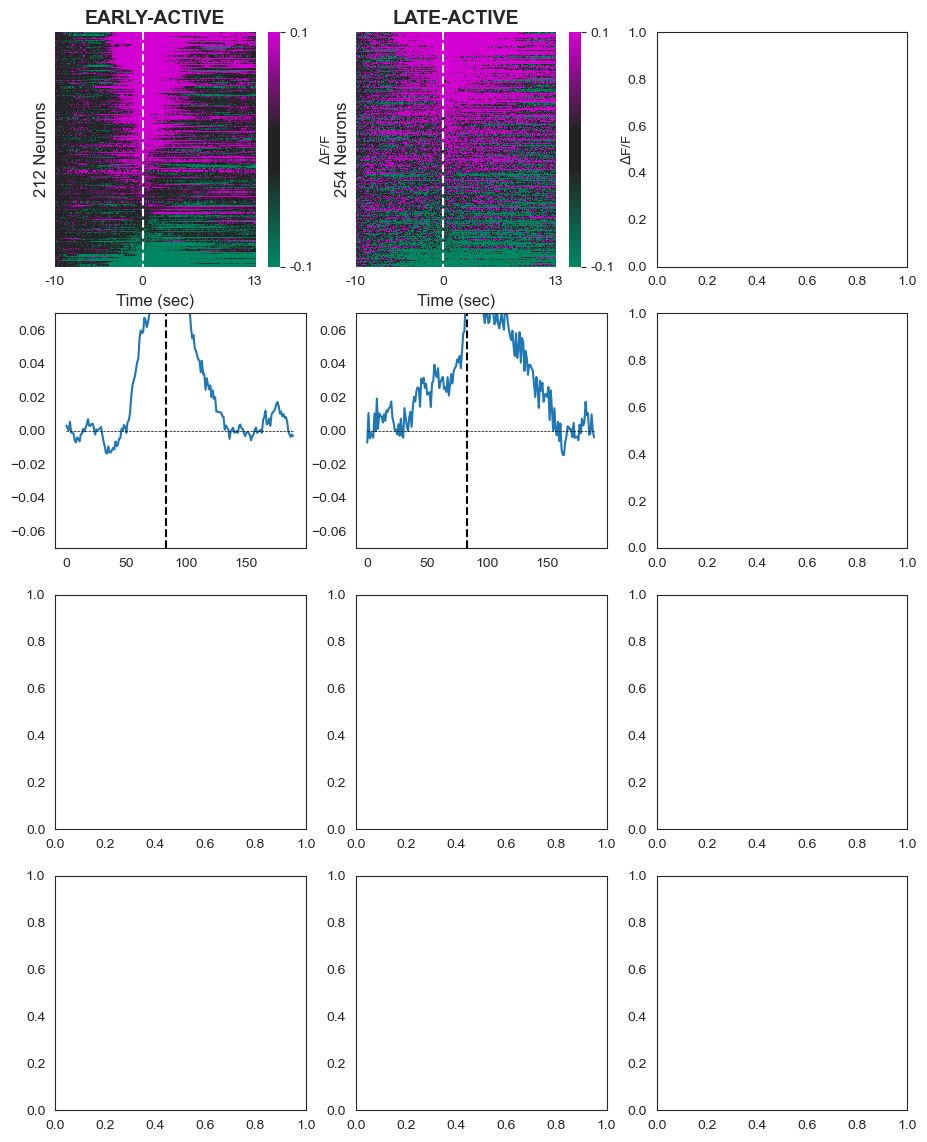

In [20]:
#plot for female active and inactive data

# initialize the plot
# 2 rows and 3 columns of graphs; may end up with blank column
fig, axs = plt.subplots(4, 3, figsize=(11, 14))
sns.set_style('white')

# setting max/min variables
cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax

# early active plots
ax = axs[0, 0]

# heatmap
hm = sns.heatmap(females_early_active_minus_baseline[sortresponse_females_early_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1]) #<-- set tick index
ax.set(xticklabels=["-10", "0", "13"]) #<-- set tick labels

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_females_early_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_females_early_active], '--k', linewidth=1.5, color='white') #leverpress line <-- change line color

# line plot
ax = axs[1, 0]
ax.plot(females_early_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

## early inactive plots (sorted to active plot)
#ax = axs[2, 0]

## heatmap
#hm = sns.heatmap(females_early_inactive_minus_baseline[sortresponse_females_early_inactive,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
#                 cmap=sns.diverging_palette(
#                     154, 308, n=230, s=100, sep=50, center='dark'),
#                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

## colorbar
#cbar = hm.collections[0].colorbar
#cbar.set_ticks([-.1, .1])
#cbar.set_ticklabels([cmin, cmax])
#ax.set(xticks=[0, pre_window_size, window_size-1])
#ax.set(xticklabels=["-10", "0","13"])

##lines and labels
#ax.grid(False)
#ax.set_title(plot_titles[0]+"-INACTIVE", fontweight="bold", fontsize=14)
#ax.set_ylabel('%s Neurons' % numneurons_females_early_inactive, fontsize=12)
#ax.set_xlabel('Time (sec)', fontsize=12)
#ax.plot([pre_window_size, pre_window_size],
#        [0, numneurons_females_early_inactive], '--', linewidth=1.5, color='white')

## line plot
#ax = axs[3, 0]
#ax.plot(females_early_inactive_mean)
#ax.set_ylim([-.07, .07])
#ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
#ax.axvline(pre_window_size, color='black', linestyle='--')

# middle active plots
ax = axs[0, 1]

# heatmap
hm = sns.heatmap(females_middle_active_minus_baseline[sortresponse_females_middle_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_females_middle_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_females_middle_active], '--', linewidth=1.5, color='white')

# line plot
ax = axs[1, 1]
ax.plot(females_middle_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

## middle inactive plots
#ax = axs[2, 1]

## heatmap
#hm = sns.heatmap(females_middle_inactive_minus_baseline[sortresponse_females_middle_inactive,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
#                 cmap=sns.diverging_palette(
#                     154, 308, n=230, s=100, sep=50, center='dark'),
#                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

## colorbar
#cbar = hm.collections[0].colorbar
#cbar.set_ticks([-.1, .1])
#cbar.set_ticklabels([cmin, cmax])
#ax.set(xticks=[0, pre_window_size, window_size-1])
#ax.set(xticklabels=["-10", "0","13"])

##lines and labels
#ax.grid(False)
#ax.set_title(plot_titles[1]+"-INACTIVE", fontweight="bold", fontsize=14)
#ax.set_ylabel('%s Neurons' % numneurons_females_middle_inactive, fontsize=12)
#ax.set_xlabel('Time (sec)', fontsize=12)
#ax.plot([pre_window_size, pre_window_size],
#        [0, numneurons_females_middle_inactive], '--', linewidth=1.5, color='white')

## line plot
#ax = axs[3, 1]
#ax.plot(females_middle_inactive_mean)
#ax.set_ylim([-.07, .07])
#ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
#ax.axvline(pre_window_size, color='black', linestyle='--')

## late active plots
#ax = axs[0, 2]

## heatmap
#hm = sns.heatmap(females_late_active_minus_baseline[sortresponse_females_late_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
#                 cmap=sns.diverging_palette(
#                     154, 308, n=230, s=100, sep=50, center='dark'),
#                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

## color bar
#cbar = hm.collections[0].colorbar
#cbar.set_ticks([-.1, .1])
#cbar.set_ticklabels([cmin, cmax])
#ax.set(xticks=[0, pre_window_size, window_size-1])
#ax.set(xticklabels=["-10", "0","13"])

##lines and labels
#ax.grid(False)
#ax.set_title(plot_titles[2]+"-ACTIVE", fontweight="bold", fontsize=14)
#ax.set_ylabel('%s Neurons' % numneurons_females_late_active, fontsize=12)
#ax.set_xlabel('Time (sec)', fontsize=12)
#ax.plot([pre_window_size, pre_window_size],
#        [0, numneurons_females_late_active], '--', linewidth=1.5, color='white')

## line plot
#ax = axs[1, 2]
#ax.plot(females_late_active_mean)
#ax.set_ylim([-.07, .07])
#ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
#ax.axvline(pre_window_size, color='black', linestyle='--')

## late inactive plots
#ax = axs[2, 2]

## heatmap
#hm = sns.heatmap(females_late_inactive_minus_baseline[sortresponse_females_late_inactive,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
#                 cmap=sns.diverging_palette(
#                     154, 308, n=230, s=100, sep=50, center='dark'),
#                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

## colorbar
#cbar = hm.collections[0].colorbar
#cbar.set_ticks([-.1, .1])
#cbar.set_ticklabels([cmin, cmax])
#ax.set(xticks=[0, pre_window_size, window_size-1])
#ax.set(xticklabels=["-10", "0", "13"])

##lines and labels
#ax.grid(False)
#ax.set_title(plot_titles[2]+"-INACTIVE", fontweight="bold", fontsize=14)
#ax.set_ylabel('%s Neurons' % numneurons_females_late_inactive, fontsize=12)
#ax.set_xlabel('Time (sec)', fontsize=12)
#ax.plot([pre_window_size, pre_window_size],
#        [0, numneurons_females_late_inactive], '--', linewidth=1.5, color='white')

## line plot
#ax = axs[3, 2]
#ax.plot(females_late_inactive_mean)
#ax.set_ylim([-.07, .07])
#ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
#ax.axvline(pre_window_size, color='black', linestyle='--')


In [21]:
FvM_results = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\female-vs-male_analysis\extinction\results'

#save fig
fig.savefig(os.path.join(FvM_results, 'PFC_HEROIN_SA_Extinction_female-active_population_heatmaps.PDF'), format='PDF')
fig.savefig(os.path.join(FvM_results, 'PFC_HEROIN_SA_Extinction_female-active_population_heatmaps.PNG'), format='PNG')

C:\Users\jboqu\AppData\Local\Temp\ipykernel_30432\1616811951.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([pre_window_size, pre_window_size],


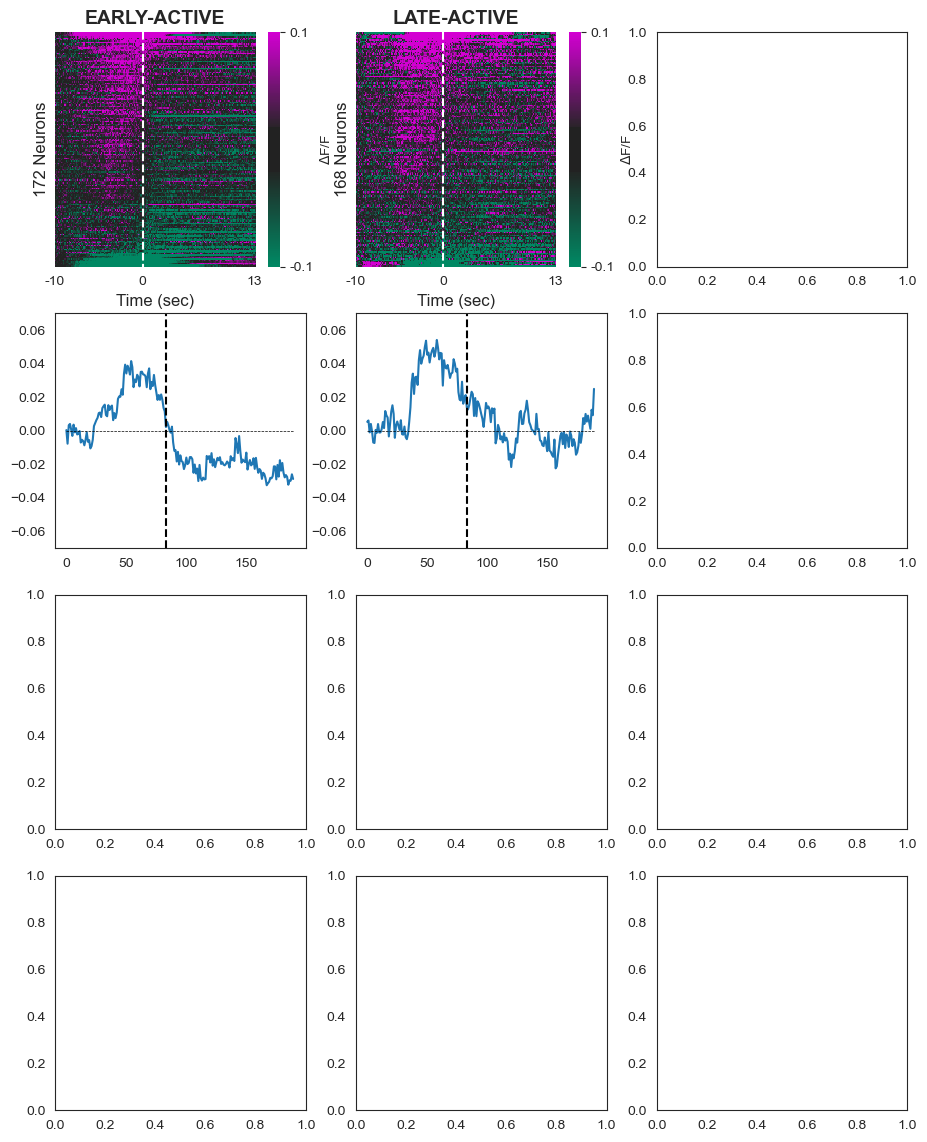

In [22]:
#plot for male active and inactive data

# initialize the plot
# 2 rows and 3 columns of graphs; may end up with blank column
fig, axs = plt.subplots(4, 3, figsize=(11, 14))
sns.set_style('white')

# setting max/min variables
cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax

# early active plots
ax = axs[0, 0]

# heatmap
hm = sns.heatmap(males_early_active_minus_baseline[sortresponse_males_early_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1]) #<-- set tick index
ax.set(xticklabels=["-10", "0", "13"]) #<-- set tick labels

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_males_early_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_males_early_active], '--k', linewidth=1.5, color='white') #leverpress line <-- change line color

# line plot
ax = axs[1, 0]
ax.plot(males_early_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

## early inactive plots (sorted to active plot)
#ax = axs[2, 0]

## heatmap
#hm = sns.heatmap(males_early_inactive_minus_baseline[sortresponse_males_early_inactive,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
#                 cmap=sns.diverging_palette(
#                     154, 308, n=230, s=100, sep=50, center='dark'),
#                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

## colorbar
#cbar = hm.collections[0].colorbar
#cbar.set_ticks([-.1, .1])
#cbar.set_ticklabels([cmin, cmax])
#ax.set(xticks=[0, pre_window_size, window_size-1])
#ax.set(xticklabels=["-10", "0","13"])

##lines and labels
#ax.grid(False)
#ax.set_title(plot_titles[0]+"-INACTIVE", fontweight="bold", fontsize=14)
#ax.set_ylabel('%s Neurons' % numneurons_males_early_inactive, fontsize=12)
#ax.set_xlabel('Time (sec)', fontsize=12)
#ax.plot([pre_window_size, pre_window_size],
#        [0, numneurons_males_early_inactive], '--', linewidth=1.5, color='white')

## line plot
#ax = axs[3, 0]
#ax.plot(males_early_inactive_mean)
#ax.set_ylim([-.07, .07])
#ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
#ax.axvline(pre_window_size, color='black', linestyle='--')

# middle active plots
ax = axs[0, 1]

# heatmap
hm = sns.heatmap(males_middle_active_minus_baseline[sortresponse_males_middle_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_males_middle_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_males_middle_active], '--', linewidth=1.5, color='white')

# line plot
ax = axs[1, 1]
ax.plot(males_middle_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

## middle inactive plots
#ax = axs[2, 1]

## heatmap
#hm = sns.heatmap(males_middle_inactive_minus_baseline[sortresponse_males_middle_inactive,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
#                 cmap=sns.diverging_palette(
#                     154, 308, n=230, s=100, sep=50, center='dark'),
#                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

## colorbar
#cbar = hm.collections[0].colorbar
#cbar.set_ticks([-.1, .1])
#cbar.set_ticklabels([cmin, cmax])
#ax.set(xticks=[0, pre_window_size, window_size-1])
#ax.set(xticklabels=["-10", "0","13"])

##lines and labels
#ax.grid(False)
#ax.set_title(plot_titles[1]+"-INACTIVE", fontweight="bold", fontsize=14)
#ax.set_ylabel('%s Neurons' % numneurons_males_middle_inactive, fontsize=12)
#ax.set_xlabel('Time (sec)', fontsize=12)
#ax.plot([pre_window_size, pre_window_size],
#        [0, numneurons_males_middle_inactive], '--', linewidth=1.5, color='white')

## line plot
#ax = axs[3, 1]
#ax.plot(males_middle_inactive_mean)
#ax.set_ylim([-.07, .07])
#ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
#ax.axvline(pre_window_size, color='black', linestyle='--')

## late active plots
#ax = axs[0, 2]

## heatmap
#hm = sns.heatmap(males_late_active_minus_baseline[sortresponse_males_late_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
#                 cmap=sns.diverging_palette(
#                     154, 308, n=230, s=100, sep=50, center='dark'),
#                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

## color bar
#cbar = hm.collections[0].colorbar
#cbar.set_ticks([-.1, .1])
#cbar.set_ticklabels([cmin, cmax])
#ax.set(xticks=[0, pre_window_size, window_size-1])
#ax.set(xticklabels=["-10", "0","13"])

##lines and labels
#ax.grid(False)
#ax.set_title(plot_titles[2]+"-ACTIVE", fontweight="bold", fontsize=14)
#ax.set_ylabel('%s Neurons' % numneurons_males_late_active, fontsize=12)
#ax.set_xlabel('Time (sec)', fontsize=12)
#ax.plot([pre_window_size, pre_window_size],
#        [0, numneurons_males_late_active], '--', linewidth=1.5, color='white')

## line plot
#ax = axs[1, 2]
#ax.plot(males_late_active_mean)
#ax.set_ylim([-.07, .07])
#ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
#ax.axvline(pre_window_size, color='black', linestyle='--')

## late inactive plots
#ax = axs[2, 2]

## heatmap
#hm = sns.heatmap(males_late_inactive_minus_baseline[sortresponse_males_late_inactive,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
#                 cmap=sns.diverging_palette(
#                     154, 308, n=230, s=100, sep=50, center='dark'),
#                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

## colorbar
#cbar = hm.collections[0].colorbar
#cbar.set_ticks([-.1, .1])
#cbar.set_ticklabels([cmin, cmax])
#ax.set(xticks=[0, pre_window_size, window_size-1])
#ax.set(xticklabels=["-10", "0", "13"])

##lines and labels
#ax.grid(False)
#ax.set_title(plot_titles[2]+"-INACTIVE", fontweight="bold", fontsize=14)
#ax.set_ylabel('%s Neurons' % numneurons_males_late_inactive, fontsize=12)
#ax.set_xlabel('Time (sec)', fontsize=12)
#ax.plot([pre_window_size, pre_window_size],
#        [0, numneurons_males_late_inactive], '--', linewidth=1.5, color='white')

## line plot
#ax = axs[3, 2]
#ax.plot(males_late_inactive_mean)
#ax.set_ylim([-.07, .07])
#ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
#ax.axvline(pre_window_size, color='black', linestyle='--')


In [23]:
FvM_results = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\female-vs-male_analysis\extinction\results'

#save fig
fig.savefig(os.path.join(FvM_results, 'PFC_HEROIN_SA_Extinction_male-active_population_heatmaps.PDF'), format='PDF')
fig.savefig(os.path.join(FvM_results, 'PFC_HEROIN_SA_Extinction_male-active_population_heatmaps.PNG'), format='PNG')